In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.wrappers import LdaMallet

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim 
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [3]:
df=pd.read_csv('got_scripts_breakdown.csv', sep=';')
df.head()

,Column1,Season,Episode,Sentence,Name,N_serie,N_Season,Emision Date
0,1,Season 1,winter is coming,What d’you expect? They’re savages One lot ste...,waymar royce,1,1,17/04/2011
1,2,Season 1,winter is coming,I’ve never seen wildlings do a thing like this...,will,1,1,17/04/2011
2,3,Season 1,winter is coming,How close did you get?,waymar royce,1,1,17/04/2011
3,4,Season 1,winter is coming,Close as any man would,will,1,1,17/04/2011
4,5,Season 1,winter is coming,We should head back to the wall,gared,1,1,17/04/2011


In [4]:
# Convert to list
data = df.Sentence.values.tolist()

In [5]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['what', 'you', 'expect', 'they', 're', 'savages', 'one', 'lot', 'steals', 'goat', 'from', 'another', 'lot', 'and', 'before', 'you', 'know', 'it', 'they', 're', 'ripping', 'each', 'other', 'to', 'pieces']]


In [6]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['what', 'you', 'expect', 'they', 're', 'savages', 'one', 'lot', 'steals', 'goat', 'from', 'another', 'lot', 'and', 'before', 'you', 'know', 'it', 'they', 're', 'ripping', 'each_other', 'to', 'pieces']


In [7]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [8]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['expect', 'savage', 'lot', 'steal', 'goat', 'lot', 'know', 'rip', 'piece']]


In [9]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 2), (4, 1), (5, 1), (6, 1), (7, 1)]]


In [10]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('expect', 1),
  ('goat', 1),
  ('know', 1),
  ('lot', 2),
  ('piece', 1),
  ('rip', 1),
  ('savage', 1),
  ('steal', 1)]]

In [11]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [12]:
# Print the Keyword in the 20 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.236*"way" + 0.115*"fuck" + 0.098*"mean" + 0.076*"city" + 0.058*"choose" + '
  '0.049*"someone" + 0.048*"old" + 0.039*"robert" + 0.034*"new" + '
  '0.027*"hunt"'),
 (1,
  '0.181*"never" + 0.180*"thing" + 0.127*"hand" + 0.127*"ever" + 0.106*"wall" '
  '+ 0.090*"head" + 0.060*"life" + 0.038*"south" + 0.000*"not" + 0.000*"be"'),
 (2,
  '0.391*"know" + 0.258*"want" + 0.199*"father" + 0.043*"hold" + 0.028*"lie" + '
  '0.000*"not" + 0.000*"be" + 0.000*"s" + 0.000*"have" + 0.000*"make"'),
 (3,
  '0.355*"look" + 0.275*"think" + 0.131*"die" + 0.077*"ask" + 0.061*"bran" + '
  '0.000*"not" + 0.000*"be" + 0.000*"s" + 0.000*"turn" + 0.000*"walk"'),
 (4,
  '0.442*"man" + 0.184*"king" + 0.117*"run" + 0.081*"sister" + '
  '0.034*"mountain" + 0.033*"rest" + 0.007*"lion" + 0.004*"andal" + '
  '0.000*"quick" + 0.000*"not"'),
 (5,
  '0.269*"take" + 0.215*"jon" + 0.117*"love" + 0.066*"anything" + '
  '0.052*"kings_lande" + 0.048*"raven" + 0.026*"casterly_rock" + '
  '0.026*"afraid" + 0.025*"water"

In [13]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -20.389114222279375

Coherence Score:  0.35023385952440883


In [14]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
10     0.292397 -0.319813       1        1  9.659730
2      0.142032  0.273616       2        1  8.084135
17     0.080807  0.072132       3        1  7.693736
8      0.076901  0.064263       4        1  7.177997
4      0.057471  0.040022       5        1  6.723186
1      0.083146  0.074420       6        1  5.929384
11    -0.030039 -0.016890       7        1  5.898858
12     0.021858  0.009421       8        1  5.866696
9      0.046858  0.029367       9        1  5.396763
0     -0.029517 -0.016837      10        1  4.966001
18     0.033822  0.018323      11        1  4.771087
3      0.049711  0.032106      12        1  4.619425
5     -0.014111 -0.010192      13        1  4.373591
7     -0.040561 -0.020423      14        1  4.349692
6     -0.104164 -0.035792      15        1  3.546955
13    -0.119616 -0.038157      16        1  2.932845
19    -0.114255 -0.037378      17        1  2.543047
15    -0.127685 -0.039074      18        1  2.403475
16    -0.150126 -0.039965      19        1  2.035934
14    -0.154928 -0.039148      20        1  1.027459, topic_info=     Category         Freq      Term        Total  loglift  logprob
53    Default  4950.000000        do  4950.000000  30.0000  30.0000
16    Default  3803.000000       man  3803.000000  29.0000  29.0000
2     Default  4041.000000      know  4041.000000  28.0000  28.0000
90    Default  3042.000000      come  3042.000000  27.0000  27.0000
11    Default  2692.000000       see  2692.000000  26.0000  26.0000
48    Default  2752.000000        go  2752.000000  25.0000  25.0000
44    Default  2674.000000      want  2674.000000  24.0000  24.0000
112   Default  2103.000000      look  2103.000000  23.0000  23.0000
91    Default  1928.000000      tell  1928.000000  22.0000  22.0000
15    Default  2412.000000       get  2412.000000  21.0000  21.0000
42    Default  1583.000000       say  1583.000000  20.0000  20.0000
18    Default  1768.000000      back  1768.000000  19.0000  19.0000
49    Default  2060.000000    father  2060.000000  18.0000  18.0000
80    Default  2013.000000      lord  2013.000000  17.0000  17.0000
29    Default  1629.000000     think  1629.000000  16.0000  16.0000
33    Default  1815.000000      kill  1815.000000  15.0000  15.0000
151   Default  1507.000000      take  1507.000000  14.0000  14.0000
125   Default  1504.000000       way  1504.000000  13.0000  13.0000
114   Default  1587.000000      king  1587.000000  12.0000  12.0000
102   Default  1653.000000      need  1653.000000  11.0000  11.0000
116   Default  1354.000000     north  1354.000000  10.0000  10.0000
40    Default  1324.000000      good  1324.000000   9.0000   9.0000
210   Default  1282.000000     queen  1282.000000   8.0000   8.0000
10    Default  1376.000000     never  1376.000000   7.0000   7.0000
17    Default  1662.000000     would  1662.000000   6.0000   6.0000
12    Default  1367.000000     thing  1367.000000   5.0000   5.0000
72    Default  1202.000000       jon  1202.000000   4.0000   4.0000
148   Default  1106.000000      give  1106.000000   3.0000   3.0000
31    Default  1040.000000     could  1040.000000   2.0000   2.0000
194   Default  1232.000000      long  1232.000000   1.0000   1.0000
...       ...          ...       ...          ...      ...      ...
6694  Topic20     0.079185   mindful     2.166975   1.2688  -9.7172
6695  Topic20     0.079185      mite     2.166975   1.2688  -9.7172
5565  Topic20     0.079185     expel     2.166975   1.2688  -9.7172
2693  Topic20     0.079191      kick     2.167133   1.2688  -9.7172
2593  Topic20     0.079189    belove     2.167107   1.2688  -9.7172
485   Topic20     0.079200      real     2.167466   1.2687  -9.7171
910   Topic20     0.079216    happen     2.168087   1.2687  -9.7169
389   Topic20     0.079209     trust     2.167867   1.2687  -9.7169
435   Topic20     0.079219     great     2.168316   1.2686  -9.7168
343

In [16]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
# mallet_path = '/Users/joycechen/Desktop/ML/SM_Project/mallet-2.0.8/bin/mallet'  # update this path
# ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [15]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
#         model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [16]:

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=60, step=6)


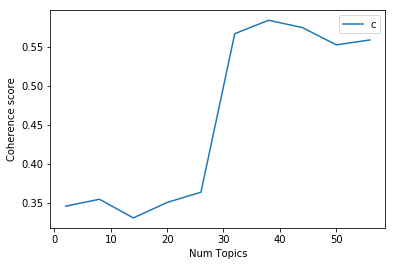

In [17]:
# Show graph
limit=60; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [18]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3455
Num Topics = 8  has Coherence Value of 0.3543
Num Topics = 14  has Coherence Value of 0.3304
Num Topics = 20  has Coherence Value of 0.3502
Num Topics = 26  has Coherence Value of 0.3634
Num Topics = 32  has Coherence Value of 0.567
Num Topics = 38  has Coherence Value of 0.5843
Num Topics = 44  has Coherence Value of 0.5749
Num Topics = 50  has Coherence Value of 0.5527
Num Topics = 56  has Coherence Value of 0.559


In [19]:
# Select the model and print the topics
optimal_model = model_list[4]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(11,
  '0.000*"bash" + 0.000*"mero" + 0.000*"convinced" + 0.000*"entertainment" + '
  '0.000*"appreciation" + 0.000*"countless" + 0.000*"yap" + 0.000*"collect" + '
  '0.000*"titan" + 0.000*"pauper"'),
 (20,
  '0.000*"bash" + 0.000*"mero" + 0.000*"convinced" + 0.000*"entertainment" + '
  '0.000*"appreciation" + 0.000*"countless" + 0.000*"yap" + 0.000*"collect" + '
  '0.000*"titan" + 0.000*"pauper"'),
 (15,
  '0.393*"true" + 0.001*"saw" + 0.000*"not" + 0.000*"s" + 0.000*"be" + '
  '0.000*"everything" + 0.000*"friend" + 0.000*"record" + 0.000*"have" + '
  '0.000*"slow"'),
 (12,
  '0.267*"rule" + 0.213*"god" + 0.000*"s" + 0.000*"not" + 0.000*"wrong" + '
  '0.000*"smile" + 0.000*"right" + 0.000*"stand" + 0.000*"be" + 0.000*"help"'),
 (13,
  '0.296*"sword" + 0.261*"head" + 0.057*"hunt" + 0.051*"arm" + 0.047*"bow" + '
  '0.046*"pass" + 0.037*"swing" + 0.000*"quick" + 0.000*"arya" + 0.000*"not"'),
 (14,
  '0.135*"old" + 0.130*"wildling" + 0.124*"mountain" + 0.114*"order" + '
  '0.101*"young" 